In [11]:
import pandas as pd
import numpy as np
import torch
df_spectra = pd.read_csv('../../data/spectra.csv').T
print(df_spectra.shape)
df_spectra.reset_index(inplace=False)
df_spectra.columns = range(len(df_spectra.columns))
data_sp = df_spectra.values.astype(np.float64)
print(data_sp.shape)
data_scaled_sp = data_sp / np.max(data_sp)
# Separate wavelengths and fluxes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming `data` is your dataset with shape [17, 10001]
# wavelengths = data[:, 0]  # Shape: [17]
fluxes_sp = data_sp[:, :]  # Transpose to get shape [10000, 17]
print(fluxes_sp.shape)
# Prepare inputs for the model
df_photo = pd.read_csv('../../data/interpolated_spectra.csv').T
print(df_photo.shape)
df_photo.reset_index(inplace=False)
df_photo.columns = range(len(df_spectra.columns))
data_ph = df_photo.values.astype(np.float64)
print(data_ph.shape)
data_scaled_ph = data_ph / np.max(data_ph)
# Separate wavelengths and fluxes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming `data` is your dataset with shape [17, 10001]
df_wavelengths = pd.read_csv("../../data/interpolated_spectra.csv").T
df_wavelengths.reset_index(inplace=True)
df_wavelengths.columns = range(len(df_wavelengths.columns))
df_wavelengths = df_wavelengths.values.astype(np.float64)
df_wavelengths_scaled = df_wavelengths / np.max(df_wavelengths)
data_wavelengths_photo = df_wavelengths[:, 0]  # Shape: [17]
fluxes_ph = data_ph[:, 0:]  # Transpose to get shape [10000, 17]
# Spectra
df_wavelengths_spectra = pd.read_csv("../../data/spectra.csv").T
df_wavelengths_spectra.reset_index(inplace=True)
df_wavelengths_spectra.columns = range(len(df_wavelengths_spectra.columns))
df_wavelengths_spectra = df_wavelengths_spectra.values.astype(np.float64)
df_wavelengths_scaled_spectra = df_wavelengths_spectra / np.max(df_wavelengths_spectra)
data_wavelengths_spectra = df_wavelengths_spectra[:, 0]  # Shape: [17]


(206, 10000)
(206, 10000)
(206, 10000)
(17, 10000)
(17, 10000)


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim



In [13]:
batch_size = 1

In [14]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class SpectraDataset(Dataset):
    def __init__(self, photometry_data, spectra_data):
        """
        Custom Dataset for loading photometry and spectra data.
        
        Parameters:
            photometry_data (numpy.ndarray): Shape (num_samples, 17)
            spectra_data (numpy.ndarray): Shape (num_samples, 206)
        """
        # Check if data shapes are compatible
        assert photometry_data.shape[0] == spectra_data.shape[0], "Mismatch in number of samples between photometry and spectra data"
        
        # Store data
        self.photometry = photometry_data  # Shape (num_samples, 17)
        self.spectra = spectra_data        # Shape (num_samples, 206)
        
        # Convert to torch tensors
        self.photometry = torch.tensor(self.photometry, dtype=torch.float32)
        self.spectra = torch.tensor(self.spectra, dtype=torch.float32)
    
    def __len__(self):
        return len(self.photometry)
    
    def __getitem__(self, idx):
        # Returns a tuple: (spectra, photometry)
        return self.spectra[idx], self.photometry[idx]

# Initialize dataset and dataloader
dataset = SpectraDataset(data_scaled_ph.T, data_scaled_sp.T)
dataloader = DataLoader(dataset, batch_size, shuffle=True, drop_last=True)  # Reduce batch size


# Diffusion Model


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Swish activation function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Residual Block as depicted in the diagram
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.swish = Swish()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.swish(self.conv1(x))
        out = self.conv2(out)
        out += x  # Residual connection
        return self.relu(out)

# TSDiff Architecture based on the diagram
class TSDiff(nn.Module):
    def __init__(self, input_dim, time_steps=1000, num_blocks=5, d_model=64, nhead=4, num_encoder_layers=2):
        super(TSDiff, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps
        self.d_model = d_model

        # Noise schedule (beta values)
        self.betas = torch.linspace(0.0001, 0.02, time_steps)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)

        # Initial Convolution Layer
        # Initial Convolution Layer
        self.initial_conv = nn.Conv1d(in_channels=17, out_channels=32, kernel_size=3, padding=1)

        # Linear layer to match d_model
        self.to_d_model = nn.Linear(32, d_model)

        # Stack of Residual Blocks
        self.residual_blocks = nn.ModuleList([
            ResidualBlock(32, 32) for _ in range(num_blocks)
        ])

        # Transformer Layer
        self.transformer_layer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers)

        # Output Layer
        self.output_conv = nn.Conv1d(in_channels=d_model, out_channels=206, kernel_size=1)


    def forward_diffusion_sample(self, x0, t):
        noise = torch.randn_like(x0)
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t])
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

    def forward(self, x, t):
        x = self.initial_conv(x)
        for block in self.residual_blocks:
            x = block(x)

        # Project to d_model dimensions
        x = self.to_d_model(x.permute(0, 2, 1))  # [batch, seq_len, d_model]
        x = x.permute(1, 0, 2)  # [seq_len, batch, d_model]

        # Pass through the Transformer layer
        x = self.transformer_layer(x, x)
        x = x.permute(1, 2, 0)  # [batch, d_model, seq_len]

        # Output Convolution
        output = self.output_conv(x)

        # Reshape to match [batch_size, 206]
        output = output.squeeze(2)  # Squeeze the sequence length if it is 1 to match real_spectra
        return output


    def denoise(self, noisy_x, t):
        predicted_noise = self.forward(noisy_x, t)
        return predicted_noise

class SelfGuidedTSDiff(nn.Module):
    def __init__(self, input_dim, time_steps=1000):
        super(SelfGuidedTSDiff, self).__init__()
        self.ts_diff = TSDiff(input_dim=input_dim, time_steps=time_steps)

    def forward(self, xt, t, y_obs=None):
        eps_hat = self.ts_diff(xt, t)
        if y_obs is not None:
            grad = torch.autograd.grad(eps_hat, xt, grad_outputs=torch.ones_like(eps_hat), create_graph=True)[0]
            eps_hat = eps_hat + 0.1 * grad * (y_obs - eps_hat)
        return eps_hat

    def denoise(self, noisy_x, t):
        return self.ts_diff.denoise(noisy_x, t)

# Define a simple dataset for demonstration
class SpectraDataset(Dataset):
    def __init__(self, photometry_file, spectra_file):
        # Load data
        self.photometry = photometry_file.T# Shape (10000, 17)
        self.spectra = spectra_file.T        # Shape (10000, 206)
        
        # Convert to torch tensors
        self.photometry = torch.tensor(self.photometry, dtype=torch.float32)
        self.spectra = torch.tensor(self.spectra, dtype=torch.float32)
    
    def __len__(self):
        return len(self.photometry)
    
    def __getitem__(self, idx):
        return self.spectra[idx], self.photometry[idx]

def scale_data(data):
        mean = data.mean(axis=1, keepdims=True)
        std = data.std(axis=1, keepdims=True)
        data = (data - mean) / std
        return data

# Load data
df_spectra = pd.read_csv('../../data/spectra.csv').T
df_spectra.columns = range(len(df_spectra.columns))
data_sp = df_spectra.values.astype(np.float64)
data_scaled_sp = data_sp / np.max(data_sp)
fluxes_sp = data_sp[:, :]  # Shape [10000, 17]

df_photo = pd.read_csv('../../data/interpolated_spectra.csv').T
df_photo.columns = range(len(df_photo.columns))
data_ph = df_photo.values.astype(np.float64)
data_scaled_ph = data_ph / np.max(data_ph)
fluxes_ph = data_ph[:, :]  # Shape [10000, 17]
# Initialize dataset and dataloader
photometry_file = '../../data/interpolated_spectra.csv'
spectra_file = '../../data/spectra.csv'
# dataset = SpectraDataset(photometry_file, spectra_file)
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
dataset = SpectraDataset(data_scaled_ph, data_scaled_sp)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, drop_last=True)
# Initialize Model, Optimizer, and Loss
input_dim = 17
time_steps = 1000
model = SelfGuidedTSDiff(input_dim=input_dim, time_steps=time_steps).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training Example
num_epochs = 100


for epoch in range(num_epochs):
    model.train()

    for i, (real_spectra, photometry_data) in enumerate(dataloader):
        real_spectra = real_spectra.to(device)
        photometry_data = photometry_data.to(device)
        # print(photometry_data.shape)
        # Randomly generate time steps for each sample in the batch
        t = torch.randint(0, time_steps, (real_spectra.size(0),)).to(device)

        # Reshape photometry data to be [batch_size, input_dim, seq_len]
        photometry_data = photometry_data.unsqueeze(2)  # Ensure [batch_size, 17, 1]

        # Forward pass
        output = model.forward(photometry_data, t)

        # Compute loss
        loss = criterion(output, real_spectra)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")
torch.save(model.state_dict(), "./diff_model.pth")


c:\Users\vasil\anaconda3\envs\pytorch_env\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


torch.Size([1, 206])
dataloader photo torch.Size([1, 17, 1])
torch.Size([10000, 17, 1])
this is the generated torch.Size([10000, 206])
(17,)
(206,) (17, 1) (206,)


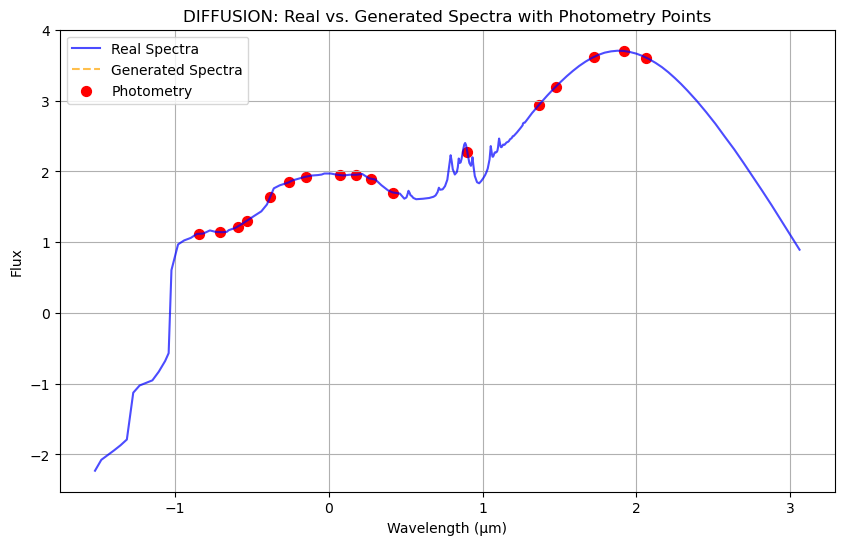

In [16]:

# Plotting Example
def plot_spectra(real_spectra, photometry, generated_spectra, photometry_wavelengths, spectra_wavelengths, index=1):
    # Convert tensors to numpy for plotting
    real_spectra = real_spectra[0].detach().cpu().numpy()
    generated_spectra = generated_spectra[0].detach().cpu().numpy()
    photometry = photometry[0].detach().cpu().numpy()
    print(real_spectra.shape, photometry.shape, generated_spectra.shape)
    # Plotting the real spectra
    plt.figure(figsize=(10, 6))
    plt.plot(spectra_wavelengths, np.max(data_sp)*real_spectra, label='Real Spectra', color='blue', alpha=0.7)
    
    # Plotting the generated spectra
    plt.plot(spectra_wavelengths, np.max(data_ph)*generated_spectra, label='Generated Spectra', color='orange', linestyle='--', alpha=0.7)
    
    # Plotting the photometry points
    plt.scatter(photometry_wavelengths, np.max(data_ph)*photometry, label='Photometry', color='red', s=50)
    
    # Add labels and legend
    plt.xlabel('Wavelength (µm)')
    plt.ylabel('Flux')
    plt.title('DIFFUSION: Real vs. Generated Spectra with Photometry Points')
    plt.legend()
    plt.grid(True)
    plt.show()

model_diff = SelfGuidedTSDiff(input_dim=input_dim, time_steps=time_steps).to(device)
model_diff.load_state_dict(torch.load("diff_model.pth", weights_only=True))
model_diff.eval()
# Example Plot Usage
real_spectra, photometry_data = next(iter(dataloader))
print(real_spectra.shape)
real_spectra = real_spectra.to(device)
photometry_data = photometry_data.unsqueeze(2).to(device)
print("dataloader photo", photometry_data.shape)
test_photometry_data = torch.tensor(data_scaled_ph.T, dtype=torch.float32).unsqueeze(2).to(device)  # Reshape if necessary
test_spectra_data = torch.tensor(data_scaled_sp.T, dtype=torch.float32).to(device)
print(test_photometry_data.shape)
with torch.no_grad():
    generated_spectra = model_diff.forward(test_photometry_data, t)
print("this is the generated",generated_spectra.shape)
# data_scaled[:, 0]
# dataspectr[:, 0]
# Define wavelengths for plotting
photometry_wavelengths = data_wavelengths_photo   # 17 photometry wavelength points
print(photometry_wavelengths.shape)
spectra_wavelengths =  data_wavelengths_spectra 
plot_spectra(test_spectra_data, test_photometry_data, generated_spectra, photometry_wavelengths, spectra_wavelengths, index=0)


In [17]:
def compute_chi_squared(real_spectra, generated_spectra):
    # Convert tensors to numpy arrays for computation
    real_spectra = real_spectra.cpu().numpy()
    generated_spectra = generated_spectra.cpu().numpy()

    # Calculate chi-squared
    chi_squared = np.sum((real_spectra - generated_spectra) ** 2 / (generated_spectra + 1e-8))  # Adding epsilon to avoid division by zero
    return chi_squared

# Example chi-squared computation
with torch.no_grad():
    generated_spectra = model_diff.forward(test_photometry_data, t)
    print("Shape of generated_spectra before squeeze:", generated_spectra.shape)

    # Ensure the correct dimension exists before squeezing
    if len(generated_spectra.shape) == 3:
        generated_spectra = generated_spectra.squeeze(2)

# Ensure shapes match for real and generated spectra
print("Shape of real_spectra before squeeze:", real_spectra.shape)
if len(real_spectra.shape) == 3:
    real_spectra = real_spectra.squeeze(2)

chi_squared = compute_chi_squared(real_spectra, generated_spectra)

print(f"Chi-squared: {chi_squared}")


Shape of generated_spectra before squeeze: torch.Size([10000, 206])
Shape of real_spectra before squeeze: torch.Size([1, 206])
Chi-squared: nan


In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# def evaluate_model(model, test_photometry_data, test_spectra_data, photometry_wavelengths, spectra_wavelengths):
#     model.eval()
    
#     with torch.no_grad():
#         # Generate predictions
#         generated_spectra = model.forward(test_photometry_data, t)
        
#         # Calculate metrics
#         mse = mean_squared_error(test_spectra_data.cpu(), generated_spectra.cpu())
#         mae = mean_absolute_error(test_spectra_data.cpu(), generated_spectra.cpu())
        
#         print(f"Test MSE: {mse}")
#         print(f"Test MAE: {mae}")

#     # Visualize the comparison for a few samples
#     n_samples = 2  # Number of samples to visualize
#     fig, axes = plt.subplots(n_samples, 1, figsize=(10, 2 * 3))
    
#     for i in range(n_samples):
#         real_sample = test_spectra_data[i].cpu().numpy()
#         photometry_data = test_photometry_data[i].cpu().numpy()
#         generated_sample = generated_spectra[i].cpu().numpy()
        
#         axes[i].plot(spectra_wavelengths, real_sample, label="Real Spectrum", color="blue")
#         axes[i].scatter(photometry_wavelengths, photometry_data, label="Real Spectrum", color="red")
#         axes[i].plot(spectra_wavelengths, generated_sample, label="Generated Spectrum", color="orange", linestyle="--")
#         axes[i].legend()
#         axes[i].set_title(f"Sample {i+1}")
    
#     plt.tight_layout()
#     plt.show()

# # After training, evaluate on a test dataset
# test_photometry_data = torch.tensor(data_scaled_ph, dtype=torch.float32).to(device)  # Reshape if necessary
# test_spectra_data = torch.tensor(data_scaled_sp, dtype=torch.float32).to(device)
# photometry_wavelengths = data_wavelengths_photo   # 17 photometry wavelength points
# spectra_wavelengths = data_wavelengths_spectra   # 17 photometry wavelength points

# evaluate_model(model, test_photometry_data, test_spectra_data, photometry_wavelengths, spectra_wavelengths)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Embedding and Recovery Networks ###
class EmbeddingNetwork(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(EmbeddingNetwork, self).__init__()
        self.fc = nn.Linear(input_dim, latent_dim)
        
    def forward(self, x):
        return torch.tanh(self.fc(x))

class RecoveryNetwork(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(RecoveryNetwork, self).__init__()
        self.fc = nn.Linear(latent_dim, output_dim)
        
    def forward(self, x):
        return self.fc(x)

### Generator with Transformer Encoder ###
class TransformerGenerator(nn.Module):
    def __init__(self, latent_dim, output_dim, nhead, hidden_dim, num_layers):
        super(TransformerGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.transformer_layer = TransformerEncoderLayer(d_model=latent_dim, nhead=nhead, dim_feedforward=hidden_dim)
        self.transformer = TransformerEncoder(self.transformer_layer, num_layers=num_layers)
        self.fc = nn.Linear(latent_dim, output_dim)

    def forward(self, z):
        # Apply transformer and map to output space
        transformed = self.transformer(z)
        return self.fc(transformed)

### Discriminator ###
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.fc(x)

### Full TimeGAN-like Model ###
class PhotometryToSpectraModel(nn.Module):
    def __init__(self, photometry_dim, spectra_dim, latent_dim, transformer_hidden_dim, transformer_nhead, transformer_layers):
        super(PhotometryToSpectraModel, self).__init__()
        self.embedding = EmbeddingNetwork(input_dim=photometry_dim, latent_dim=latent_dim)
        self.generator = TransformerGenerator(latent_dim=latent_dim, output_dim=spectra_dim, nhead=transformer_nhead, hidden_dim=transformer_hidden_dim, num_layers=transformer_layers)
        self.recovery = RecoveryNetwork(latent_dim=latent_dim, output_dim=spectra_dim)
        self.discriminator = Discriminator(input_dim=spectra_dim)

    def forward_generator(self, photometry):
        latent = self.embedding(photometry)
        generated_spectra = self.generator(latent)
        return generated_spectra

    def forward_discriminator(self, spectra):
        return self.discriminator(spectra)

    def forward_embedding_recovery(self, photometry):
        latent = self.embedding(photometry)
        return self.recovery(latent)

### Training Function with Supervised Loss ###
def train_model(model, photometry_data, spectra_data, epochs=10000):
    criterion = nn.MSELoss()          # Supervised loss
    adversarial_loss = nn.BCELoss()   # Adversarial loss

    optimizer_G = optim.Adam(model.generator.parameters(), lr=0.001)
    optimizer_D = optim.Adam(model.discriminator.parameters(), lr=0.001)
    optimizer_ER = optim.Adam(list(model.embedding.parameters()) + list(model.recovery.parameters()), lr=0.001)

    for epoch in range(epochs):
        # Adversarial ground truths
        valid = torch.ones((spectra_data.shape[0], 1), requires_grad=False).to(device)
        fake = torch.zeros((spectra_data.shape[0], 1), requires_grad=False).to(device)

        # ========================= Train Generator with Supervised Loss =========================
        optimizer_G.zero_grad()
        generated_spectra = model.forward_generator(photometry_data)
        
        # Supervised loss between generated spectra and real spectra
        g_loss_supervised = criterion(generated_spectra, spectra_data)
        
        # Adversarial loss for generator
        g_loss_adversarial = adversarial_loss(model.forward_discriminator(generated_spectra), valid)
        
        # Total generator loss
        g_loss = g_loss_supervised + g_loss_adversarial
        g_loss.backward()
        optimizer_G.step()

        # ========================= Train Discriminator =========================
        optimizer_D.zero_grad()
        
        real_loss = adversarial_loss(model.forward_discriminator(spectra_data), valid)
        fake_loss = adversarial_loss(model.forward_discriminator(generated_spectra.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # ========================= Train Embedding and Recovery Networks =========================
        optimizer_ER.zero_grad()
        
        recovered_spectra = model.forward_embedding_recovery(photometry_data)
        er_loss = criterion(recovered_spectra, spectra_data)  # Supervised loss for embedding/recovery
        
        er_loss.backward()
        optimizer_ER.step()

        if epoch % 100 == 0:
            print(f"[Epoch {epoch}/{epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}] [ER loss: {er_loss.item()}]")
    torch.save(model.state_dict(), "./gan_model.pth")

# Instantiate the model
photometry_dim = 17
spectra_dim = 206
latent_dim = 64
transformer_hidden_dim = 128
transformer_nhead = 4
transformer_layers = 4

model = PhotometryToSpectraModel(
    photometry_dim=photometry_dim, 
    spectra_dim=spectra_dim, 
    latent_dim=latent_dim, 
    transformer_hidden_dim=transformer_hidden_dim, 
    transformer_nhead=transformer_nhead, 
    transformer_layers=transformer_layers
).to(device)

# Load data
df_spectra = pd.read_csv('../../data/spectra.csv').T
df_spectra.columns = range(len(df_spectra.columns))
data_sp = df_spectra.values.astype(np.float64)
data_scaled_sp = data_sp / np.max(data_sp)
fluxes_sp = data_sp[:, :]  # Shape [10000, 17]

df_photo = pd.read_csv('../../data/interpolated_spectra.csv').T
df_photo.columns = range(len(df_photo.columns))
data_ph = df_photo.values.astype(np.float64)
data_scaled_ph = data_ph / np.max(data_ph)
# Load your photometry and spectra data here
photometry_data = data_scaled_ph
spectra_data = data_scaled_sp
photometry_data = torch.tensor(photometry_data.T, dtype=torch.float32).to(device)
spectra_data = torch.tensor(spectra_data.T, dtype=torch.float32).to(device)

# Run training
train_model(model, photometry_data, spectra_data)


[Epoch 0/10000] [D loss: 0.6921082735061646] [G loss: 1.336179494857788] [ER loss: 0.34244558215141296]
[Epoch 100/10000] [D loss: 0.7064339518547058] [G loss: 0.7743027210235596] [ER loss: 0.008101033046841621]
[Epoch 200/10000] [D loss: 0.6922743916511536] [G loss: 0.7343016862869263] [ER loss: 0.0035124593414366245]
[Epoch 300/10000] [D loss: 0.6917812824249268] [G loss: 0.7239696383476257] [ER loss: 0.0020734115969389677]
[Epoch 400/10000] [D loss: 0.6951418519020081] [G loss: 0.7272921800613403] [ER loss: 0.0012344573624432087]
[Epoch 500/10000] [D loss: 0.693556547164917] [G loss: 0.7094716429710388] [ER loss: 0.0007951633888296783]
[Epoch 600/10000] [D loss: 0.6924824118614197] [G loss: 0.7033879160881042] [ER loss: 0.0005953677464276552]
[Epoch 700/10000] [D loss: 0.6927744746208191] [G loss: 0.7004714012145996] [ER loss: 0.0004911262076348066]
[Epoch 800/10000] [D loss: 0.6940140724182129] [G loss: 0.70041424036026] [ER loss: 0.0004200260154902935]
[Epoch 900/10000] [D loss: 0

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def evaluate_model(model, test_photometry_data, test_spectra_data, photometry_wavelengths, spectra_wavelengths):
    model_gan = PhotometryToSpectraModel(
    photometry_dim=photometry_dim, 
    spectra_dim=spectra_dim, 
    latent_dim=latent_dim, 
    transformer_hidden_dim=transformer_hidden_dim, 
    transformer_nhead=transformer_nhead, 
    transformer_layers=transformer_layers
).to(device)
    model_gan.load_state_dict(torch.load("./gan_model.pth", weights_only=True))
    model_gan.eval()
    
    with torch.no_grad():
        # Generate predictions
        generated_spectra = model_gan.forward_generator(test_photometry_data)
        
        # Calculate metrics
        mse = mean_squared_error(test_spectra_data.cpu(), generated_spectra.cpu())
        mae = mean_absolute_error(test_spectra_data.cpu(), generated_spectra.cpu())
        
        print(f"Test MSE: {mse}")
        print(f"Test MAE: {mae}")

    # Visualize the comparison for a few samples
    n_samples = 2  # Number of samples to visualize
    # fig, axes = plt.subplots(n_samples, 1, figsize=(10, 2 * 3))
    
    # for i in range(n_samples):
    real_sample = test_spectra_data[0,:].cpu().numpy()
    photometry_data = test_photometry_data[0,:].cpu().numpy()
    generated_sample = generated_spectra[0,:].cpu().numpy()
    
    plt.figure(figsize=(10, 6))
    plt.plot(spectra_wavelengths, real_sample, label='Real Spectra', color='blue', alpha=0.7)
    
    # Plotting the generated spectra
    plt.plot(spectra_wavelengths, generated_sample, label='Generated Spectra', color='orange', linestyle='--', alpha=0.7)
    
    # Plotting the photometry points
    plt.scatter(photometry_wavelengths, photometry_data, label='Photometry', color='red', s=50)
    # axes.set_title(f"Sample {i+1}")
    # Add labels and legend
    plt.xlabel('Wavelength (µm)')
    plt.ylabel('Flux')
    plt.title('GAN: Real vs. Generated Spectra with Photometry Points')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# After training, evaluate on a test dataset
print(test_photometry_data.shape)
# test_photometry_data = test_photometry_data.squeeze(2)
# test_spectra_data = torch.tensor(data_scaled_sp.T, dtype=torch.float32).to(device)
# photometry_wavelengths = data_wavelengths_photo   # 17 photometry wavelength points
# spectra_wavelengths = data_wavelengths_spectra   # 17 photometry wavelength points
print(test_photometry_data.shape, test_spectra_data.shape)
evaluate_model(model, test_photometry_data, test_spectra_data, photometry_wavelengths, spectra_wavelengths)


torch.Size([2, 17, 1])
torch.Size([2, 17, 1]) torch.Size([2, 206])


c:\Users\vasil\anaconda3\envs\pytorch_env\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


RuntimeError: mat1 and mat2 shapes cannot be multiplied (34x1 and 17x64)